# Experiment: Automated image editing with generated 3D LUTs
To prove that our model is indeed capable of the generation of image-adaptive 3D LUTs
we conduct one last experiment with paired image data. We use 600 unedited images
shot with a Sony digital camera as our ungraded images and the same images after we
have edited them in Adobe Lightroom. We use images of different settings, a wedding
photoshoot as well as an event and landscape images to provide a variety of different
scenarios to help the model generalize. The images are all edited individually, therefore
to replicate the edited images it is necessary to learn image-adaptive 3D LUTs. 

# Imports

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import numpy as np
from torchvision import transforms
from tqdm import tqdm
from PIL import Image
from IPython.display import display
import os
from torchinfo import summary
from pytorch_msssim import ssim, ms_ssim
import torch.nn.functional as F
import matplotlib.pyplot as plt
import torchvision.utils as vutils
from torch.optim.lr_scheduler import ReduceLROnPlateau

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Hyperparameters

In [3]:
batch_size = 64
lut_size = 33
learning_rate = 1e-4
num_epochs = 500
use_interpolation = True
experiment = "auto_edit_w_interpolation_01"
model_name = "auto_edit_w_interpolation_01.pth.tar"

# Dataset
The Dataset for this Experiment consists of paired Images that are *ungraded* RAW images of a Sony digital camera and *graded* JPG Images edited with Adobe Lightroom.

In [4]:
class PairedImageDataset(Dataset):
    def __init__(self, ungraded_images, graded_images, transform=None):
        self.ungraded_images = ungraded_images
        self.graded_images = graded_images
        self.transform = transform

    def __len__(self):
        return len(self.ungraded_images)

    def __getitem__(self, idx):
        # Returns an ungraded and a graded image
        ungraded = self.ungraded_images[idx]
        graded = self.graded_images[idx]
        if self.transform:
            ungraded = self.transform(ungraded)
            graded = self.transform(graded)
        return ungraded, graded

In [5]:
transform64 = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
])

In [6]:
transform = transforms.Compose([
    transforms.ToTensor(),
])

The function `load_images_from_directory` gets all images that are within a specific directory, converts them into RGB and can apply a transformation to the images. Additionally the number of images that are processed can be limited with the `num_images` parameter. The function returns a tensor of images. The tensor has the shape (number of images x width x height x channels). 

In [7]:
def load_images_from_directory(directory_path, num_images=100, apply_transform=True):
    images = []
    files = os.listdir(directory_path)
    # Ensure only images are processed
    image_files = [f for f in files if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
    
    for i, image_file in enumerate(image_files[:num_images]):
        image_path = os.path.join(directory_path, image_file)
        img = Image.open(image_path).convert('RGB')  # Convert to RGB in case of grayscale
        if apply_transform:
            img = transform64(img)  # Apply the transformations

        else:
            img = transform(img)
        images.append(img)
        
    images_tensor = torch.stack(images)
    images_tensor = images_tensor.permute(0, 2, 3, 1)
    return images_tensor

ungraded_images = load_images_from_directory('../../sony_images/wedding/original', num_images=600)
graded_images = load_images_from_directory('../../sony_images/wedding/edited', num_images=600)

# Verify the shape of the tensors
print(ungraded_images.shape)  
print(graded_images.shape)

torch.Size([600, 256, 256, 3])
torch.Size([600, 256, 256, 3])


In [8]:
ungraded_images_np = ungraded_images.numpy()
graded_images_np = graded_images.numpy()

dataset = PairedImageDataset(ungraded_images_np, graded_images_np, transform)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

# Visualization of the Dataset

In [9]:
# Function to plot a set of images in a 8x8 grid
def plot_image_grid(images, title):
    plt.figure(figsize=(8,8))
    plt.axis("off")
    plt.title(title)
    plt.imshow(np.transpose(vutils.make_grid(images.to(device)[:64], padding=2, normalize=True).cpu(),(1,2,0)))
    plt.show()

## Ungraded training Images
The following Image Grid shows the ungraded training images:

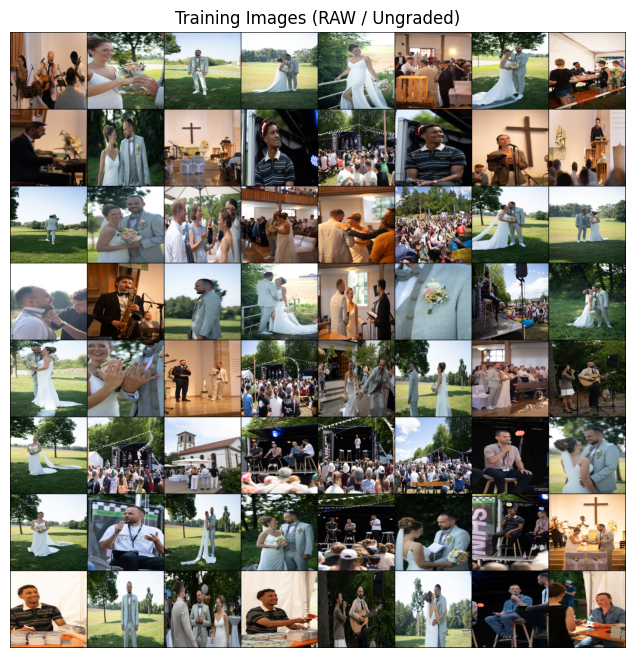

In [10]:
ungraded, graded = next(iter(dataloader))

plot_image_grid(ungraded, "Training Images (RAW / Ungraded)")

## Graded training Images
The following Image Grid shows the graded training images:

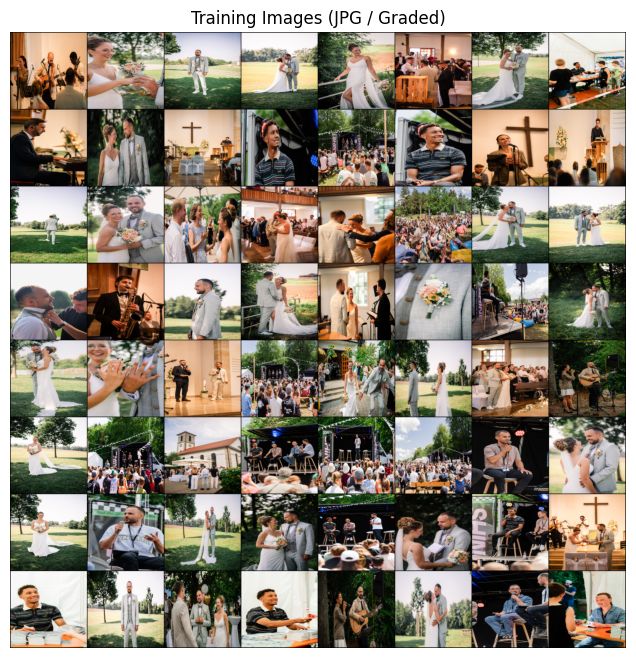

In [11]:
plot_image_grid(graded, "Training Images (JPG / Graded)")

# Apply LUT function

In [12]:
def trilinear_interpolation(luts, images):
    # Scale images to be between -1 and 1
    img = (images - 0.5) * 2.0  # Shape: [4, 3, 256, 256]
    
    # Add a singleton dimension to represent "channel" for LUT interpolation
    img = img.permute(0, 2, 3, 1).unsqueeze(1)  # Shape: [4, 1, 256, 256, 3]

    # Ensure LUT is in the correct format
    LUT = luts.permute(0, 4, 1, 2, 3)  # Shape: [4, 3, 8, 8, 8]

    # Perform grid sampling for each channel
    result = F.grid_sample(LUT, img, mode='bilinear', padding_mode='border', align_corners=True)  # [4, 3, 1, 256, 256]

    # Remove the singleton dimension and permute to the correct format
    result = result.squeeze(2)  # Remove the extra "depth" dimension: [4, 3, 256, 256]

    return result

In [13]:
def simple_approach(luts, images):
    lut = luts.view(luts.shape[0], luts.shape[2], luts.shape[2], luts.shape[2], 3)
    image_normalized = (images * luts.shape[2]-1).long()
    image_normalized = torch.clamp(image_normalized, 0, luts.shape[2]-1)
        
    r = image_normalized[:, 0, :, :]
    g = image_normalized[:, 1, :, :]
    b = image_normalized[:, 2, :, :]
        
    transformed = lut[torch.arange(luts.shape[0]).unsqueeze(-1).unsqueeze(-1), r, g, b]
    transformed = transformed.permute(0, 3, 1, 2)

# ResNet
The model used for this experiment is based on the Residual Network (ResNet) architecture proposed in the paper `Deep Residual Learning for Image Recognition`: https://arxiv.org/pdf/1512.03385

In [14]:
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(out_channels)
        
        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride),
                nn.BatchNorm2d(out_channels)
            )

    def forward(self, x):
        residual = x
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(residual)
        return F.relu(out)

Instead of the initial 7x7 convolutional layer, we use a 3x3 filter with a padding of one in the initial convolutional layer that keeps the initial resolution, in this case at 256 x 256. As another measure to adapt the model to lower image resolutions, we use just three residual blocks in comparison to four in the original implementation.
The residual blocks are identical to the ResNet implementation with a filter size of 3x3. Just as mentioned in the paper, "when the shortcuts go across feature maps of two sizes, they are performed with a stride of 2".
In general, convolutional layers are followed by batch normalization and a ReLU activation function as in the original implementation. After the residual blocks, global average pooling is performed, also following the original implementation.
Where the original implementation ends with a 1000-way fully connected layer with a softmax activation function for the task of classifying the 1000 classes in the ImageNet 2012 classification dataset, our model is adopted to generate 3D LUTs. The global average pooling layer is followed by a fully connected layer with 512 dimensions followed by ReLU activation and another fully connected layer that expands the output to the required dimensions for the 3D LUT, which is: LUT_size^3 * channels. The model can be initialized with varying LUT sizes; for an 8 bit LUT the last fully connected layer has 8 * 8 * 8 * 3 = 1536 dimensions.

Source: https://arxiv.org/pdf/1512.03385

In [15]:
class ResNetLUTGenerator(nn.Module):
    def __init__(self, lut_size=8, trilinear=True, input_channels=3):
        super(ResNetLUTGenerator, self).__init__()
        self.lut_size = lut_size
        self.trilinear = trilinear
        if trilinear:
            self.application = self._trilinear_interpolation
        else: 
            self.application = self._simple_approach
        
        # Initial convolution
        self.initial_conv = nn.Sequential(
            nn.Conv2d(input_channels, 32, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU()
        )
        
        # ResNet feature extraction
        self.layer1 = self._make_layer(32, 64, stride=2)
        self.layer2 = self._make_layer(64, 128, stride=2)
        self.layer3 = self._make_layer(128, 256, stride=2)
        
        # Global average pooling
        self.global_pool = nn.AdaptiveAvgPool2d(1)
        
        # LUT generator
        self.lut_generator = nn.Sequential(
            nn.Linear(256, 512),
            nn.ReLU(),
            nn.Linear(512, lut_size * lut_size * lut_size * 3)
        )

    def _make_layer(self, in_channels, out_channels, stride):
        return ResidualBlock(in_channels, out_channels, stride)


    def _trilinear_interpolation(self,luts, images):
        # Scale images to be between -1 and 1
        img = (images - 0.5) * 2.0  # Shape: [4, 3, 256, 256]
        
        # Add a singleton dimension to represent "channel" for LUT interpolation
        img = img.permute(0, 2, 3, 1).unsqueeze(1)  # Shape: [4, 1, 256, 256, 3]
    
        # Ensure LUT is in the correct format
        LUT = luts.permute(0, 4, 1, 2, 3)  # Shape: [4, 3, 8, 8, 8]
    
        # Perform grid sampling for each channel
        result = F.grid_sample(LUT, img, mode='bilinear', padding_mode='border', align_corners=True)  # [4, 3, 1, 256, 256]
    
        # Remove the singleton dimension and permute to the correct format
        result = result.squeeze(2)  # Remove the extra "depth" dimension: [4, 3, 256, 256]
    
        return result

    def _simple_approach(self, luts, images):
        lut = luts.view(luts.shape[0], luts.shape[2], luts.shape[2], luts.shape[2], 3)
        image_normalized = (images * luts.shape[2]-1).long()
        image_normalized = torch.clamp(image_normalized, 0, luts.shape[2]-1)
            
        r = image_normalized[:, 0, :, :]
        g = image_normalized[:, 1, :, :]
        b = image_normalized[:, 2, :, :]
            
        transformed = lut[torch.arange(luts.shape[0]).unsqueeze(-1).unsqueeze(-1), r, g, b]
        transformed = transformed.permute(0, 3, 1, 2)

        return transformed


    def forward(self, x):
        # Feature extraction
        x_orig = x  # Store original input
        x = self.initial_conv(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        
        # Global pooling and feature compression
        features = self.global_pool(x).view(x.size(0), -1)
        
        # Generate LUT
        lut = self.lut_generator(features)
        lut = lut.view(-1, self.lut_size, self.lut_size, self.lut_size, 3)
        lut = torch.sigmoid(lut)
        
        # Apply LUT to original input
        transformed = self.application(lut, x_orig)
        return transformed, lut

## Test LUT Generator

In [16]:
sample_input = torch.rand(4, 3, 256, 256).to(device)
LUTGeneratorCNN=ResNetLUTGenerator().to(device)
transformed, lut = LUTGeneratorCNN(sample_input)
print(lut.shape)
print(transformed.shape)

torch.Size([4, 8, 8, 8, 3])
torch.Size([4, 3, 256, 256])


The models architectural summary for 256 x 256 images and an 8 bit LUT is shown in the summary below, where we can see the initial convolutional layer, followed by the three residual blocks, the global average pooling layer and the fully connected layers for the 3D LUT.

In [17]:
test_model = ResNetLUTGenerator()
summary(test_model, input_size=(32, 3, 256, 256))

Layer (type:depth-idx)                   Output Shape              Param #
ResNetLUTGenerator                       [32, 3, 256, 256]         --
├─Sequential: 1-1                        [32, 32, 256, 256]        --
│    └─Conv2d: 2-1                       [32, 32, 256, 256]        896
│    └─BatchNorm2d: 2-2                  [32, 32, 256, 256]        64
│    └─ReLU: 2-3                         [32, 32, 256, 256]        --
├─ResidualBlock: 1-2                     [32, 64, 128, 128]        --
│    └─Conv2d: 2-4                       [32, 64, 128, 128]        18,496
│    └─BatchNorm2d: 2-5                  [32, 64, 128, 128]        128
│    └─Conv2d: 2-6                       [32, 64, 128, 128]        36,928
│    └─BatchNorm2d: 2-7                  [32, 64, 128, 128]        128
│    └─Sequential: 2-8                   [32, 64, 128, 128]        --
│    │    └─Conv2d: 3-1                  [32, 64, 128, 128]        2,112
│    │    └─BatchNorm2d: 3-2             [32, 64, 128, 128]        128


# Train Function

In [18]:
def display_image(image, width=256):
    tensor_image = image.detach().cpu()
    # Rearrange to HWC format and scale to [0, 255]
    image_np = np.transpose(tensor_image.numpy(), (1, 2, 0))  # Select the first image in batch and permute to HWC
    image_np = (image_np * 255).clip(0, 255).astype(np.uint8)
            
    image = Image.fromarray(image_np)
    display(image)

In [19]:
def display_images(images, titles=None):
    # Three subplots in one row
    fig, axes = plt.subplots(1, 3, figsize=(4, 2))
    
    # Convert and display each image
    for idx, (ax, img) in enumerate(zip(axes, [images[0], images[1], images[2]])):
        # Convert tensor to numpy array
        tensor_image = img.detach().cpu()
        image_np = np.transpose(tensor_image.numpy(), (1, 2, 0))
        image_np = (image_np * 255).clip(0, 255).astype(np.uint8)
        
        # Display the image
        ax.imshow(image_np)
        ax.axis('off')
        
        # Set title if provided
        if titles and idx < len(titles):
            ax.set_title(titles[idx])
    
    # Adjust layout to prevent overlap
    plt.tight_layout()
    plt.show()

In [20]:
def l2_regularization(lut):
    # Penalize large deviations in LUT values.
    return torch.mean(lut ** 2)

def smoothness_regularization(lut, lambda_smooth=0.001):
    """
    Calculate smoothness regularization for a batch of 3D LUTs that only enforces
    local consistency between neighboring values.
    
    Args:
        lut: Tensor of shape (batch_size, 3, lut_size, lut_size, lut_size)
        lambda_smooth: Smoothness weight factor (should be very small)
    
    Returns:
        Smoothness loss value
    """
    # Calculate differences with immediate neighbors only
    diff_x = torch.abs(lut[:, :, 1:, :, :] - lut[:, :, :-1, :, :])
    diff_y = torch.abs(lut[:, :, :, 1:, :] - lut[:, :, :, :-1, :])
    diff_z = torch.abs(lut[:, :, :, :, 1:] - lut[:, :, :, :, :-1])
    
    # Calculate variance in local 2x2x2 neighborhoods
    # This helps ensure smooth transitions without forcing any particular direction
    local_var_x = torch.var(torch.stack([
        lut[:, :, :-1, :-1, :-1],
        lut[:, :, 1:, :-1, :-1],
    ], dim=-1), dim=-1)
    
    local_var_y = torch.var(torch.stack([
        lut[:, :, :-1, :-1, :-1],
        lut[:, :, :-1, 1:, :-1],
    ], dim=-1), dim=-1)
    
    local_var_z = torch.var(torch.stack([
        lut[:, :, :-1, :-1, :-1],
        lut[:, :, :-1, :-1, 1:],
    ], dim=-1), dim=-1)
    
    # Combine both immediate differences and local variance
    smoothness = (
        diff_x.mean() + diff_y.mean() + diff_z.mean() +  # Immediate neighbor differences
        local_var_x.mean() + local_var_y.mean() + local_var_z.mean()  # Local variance
    )
    
    return smoothness * lambda_smooth

def calc_lut_loss(lut):
    #l2_loss = l2_regularization(lut)
    l2_loss = 0
    smoothness_loss = smoothness_regularization(lut)
    total_loss = 0.1 * l2_loss + 0.1 * smoothness_loss
    return total_loss

In [21]:
def ssim_loss(generated, target):
        """
        Structural Similarity Index Measure loss
        Args:
            generated: Generated image tensor (B, C, H, W)
            target: Target image tensor (B, C, H, W)
        """
        return 1 - ssim(generated, target, data_range=255, size_average=True)

In [22]:
def train_model(model, dataloader, optimizer, criterion, num_epochs=10):
    model.train()
    epoch_losses = [] 

    # Create ReduceLROnPlateau scheduler as in the ResNet paper - divides learning rate by 10 when the error plateaus  https://arxiv.org/pdf/1512.03385
    scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=10)
    
    for epoch in tqdm(range(num_epochs)):
        running_loss = 0.0
        for ungraded, graded in dataloader:
            ungraded, graded = ungraded.to(device), graded.to(device)

            # Forward pass
            optimizer.zero_grad()
            transformed, _ = model(ungraded)

            loss = criterion(transformed, graded) #+ ssim_loss(transformed, graded) #+ calc_lut_loss(lut)

            # Backward pass
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        avg_epoch_loss = running_loss / len(dataloader)
        epoch_losses.append(avg_epoch_loss)

        # scheduler step with average loss
        scheduler.step(avg_epoch_loss)
        
        #print(f"Epoch [{epoch + 1}/{num_epochs}], Loss: {running_loss / len(dataloader)}")
        if epoch % 50 == 0:
            display_images([ungraded[0], graded[0], transformed[0]], ["raw", "jpg", "model output"])

    return epoch_losses

# Training

In [23]:
model = ResNetLUTGenerator(lut_size=lut_size, trilinear=use_interpolation).to(device)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
criterion = nn.MSELoss()

  0%|                                                                                          | 0/500 [00:00<?, ?it/s]

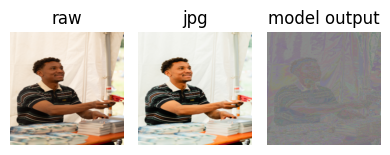

 10%|████████                                                                         | 50/500 [01:33<14:55,  1.99s/it]

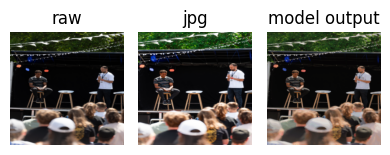

 20%|████████████████                                                                | 100/500 [03:02<11:14,  1.69s/it]

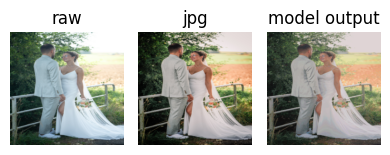

 30%|████████████████████████                                                        | 150/500 [04:31<09:09,  1.57s/it]

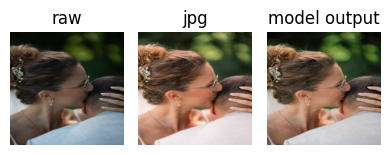

 40%|████████████████████████████████                                                | 200/500 [05:59<07:50,  1.57s/it]

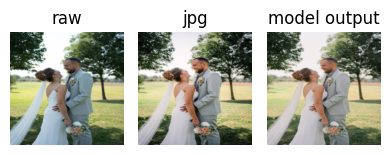

 50%|████████████████████████████████████████                                        | 250/500 [07:29<08:09,  1.96s/it]

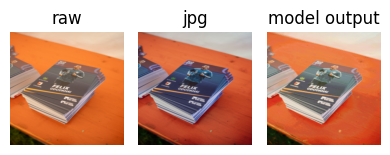

 60%|████████████████████████████████████████████████                                | 300/500 [08:55<06:11,  1.86s/it]

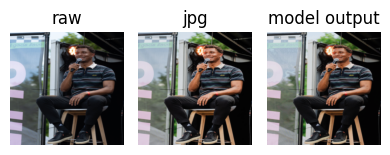

 70%|████████████████████████████████████████████████████████                        | 350/500 [10:13<03:53,  1.55s/it]

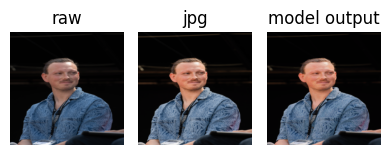

 80%|████████████████████████████████████████████████████████████████                | 400/500 [11:32<02:36,  1.57s/it]

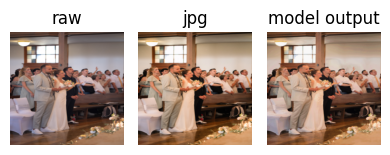

 90%|████████████████████████████████████████████████████████████████████████        | 450/500 [12:53<01:23,  1.66s/it]

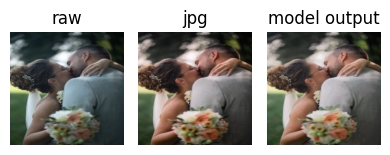

100%|████████████████████████████████████████████████████████████████████████████████| 500/500 [14:10<00:00,  1.70s/it]


In [24]:
loss_summary = train_model(model, dataloader, optimizer, criterion, num_epochs)

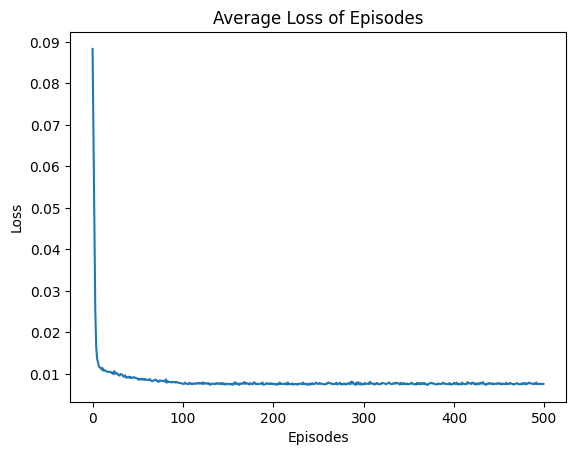

In [59]:
plt.plot(loss_summary)
# Add Title

plt.title("Average Loss of Episodes") 

# Add Axes Labels

plt.xlabel("Episodes") 
plt.ylabel("Loss") 

# Display

plt.show()

## Save Model

In [60]:
def save_checkpoint(model, optimizer, directory, filename="models/checkpoint.pth.tar"):
    print("=> Saving checkpoint")
    checkpoint = {
        "state_dict": model.state_dict(),
        "optimizer": optimizer.state_dict(),
    }
    directory = f"models/{directory}"
    # Create the directory if it doesn't exist
    if not os.path.exists(directory):
        os.makedirs(directory)
        
    torch.save(checkpoint, os.path.join(directory, filename))

In [61]:
save_checkpoint(model, optimizer, directory=experiment, filename=model_name)

=> Saving checkpoint


# Evaluation

In [112]:
eval_experiment = "auto_edit_w_interpolation_01"
eval_filepath = "auto_edit_w_interpolation_01.pth.tar"

In [113]:
eval_model = ResNetLUTGenerator(lut_size=lut_size, trilinear=use_interpolation).to(device).to(device)
eval_optimizer = optim.Adam(eval_model.parameters(), lr=learning_rate)

In [114]:
def load_checkpoint(model, optimizer, experiment, filepath):
    
    filepath = f"models/{experiment}/{filepath}"
    print(f"=> Loading checkpoint from {filepath}")
    checkpoint = torch.load(filepath, weights_only=True)
    model.load_state_dict(checkpoint["state_dict"])
    optimizer.load_state_dict(checkpoint["optimizer"])
    return model, optimizer

In [115]:
eval_generator, _ = load_checkpoint(eval_model, eval_optimizer, eval_experiment, eval_filepath)

=> Loading checkpoint from models/auto_edit_w_interpolation_01/auto_edit_w_interpolation_01.pth.tar


### Performance on Training Images

In [116]:
eval_generator.eval()
ungraded = ungraded.to(device)
edited_images, luts = eval_generator(ungraded)

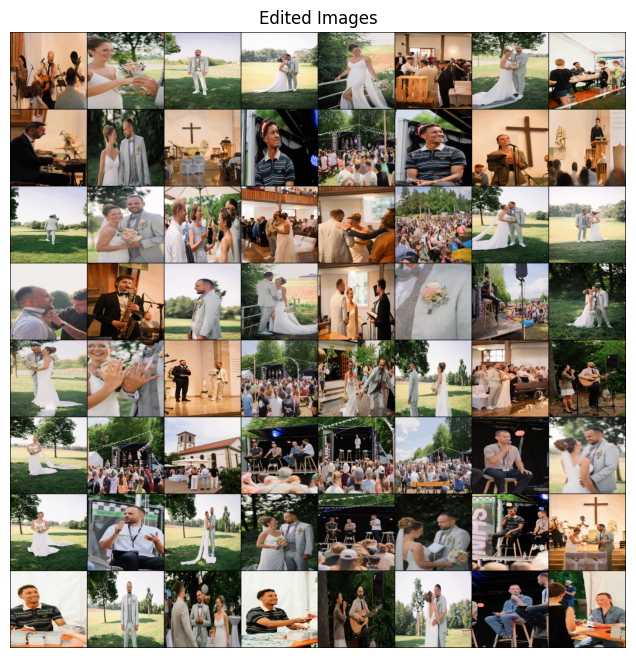

In [117]:
plot_image_grid(edited_images, "Edited Images")

### Is the generated LUT always the same?

In [118]:
luts = []
for i in range(5):
    sample_input = torch.rand(1, 3, 64, 64).to(device)
    _, lut = eval_model(sample_input)
    luts.append(lut)

In [119]:
total_difference = sum(torch.sum(torch.abs(luts[i] - luts[j])) for i in range(len(luts)) for j in range(i + 1, len(luts)))

print(f"Total sum of differences: {total_difference}")

Total sum of differences: 10895.0791015625


In [120]:
_, lut0 = eval_model(ungraded[0].unsqueeze(0))
_, lut30 = eval_model(ungraded[30].unsqueeze(0))

In [121]:
image30_lut0 = trilinear_interpolation(lut0, ungraded[30].unsqueeze(0))
image30_lut30 = trilinear_interpolation(lut30, ungraded[30].unsqueeze(0))
image0_lut30 = trilinear_interpolation(lut30, ungraded[0].unsqueeze(0))
image0_lut0 = trilinear_interpolation(lut0, ungraded[0].unsqueeze(0))

In [122]:
def display_images(images):
    # Convert each tensor image to numpy and scale to [0, 255]
    images_np = []
    for image in images:
        tensor_image = image.detach().cpu()
        image_np = np.transpose(tensor_image.numpy(), (1, 2, 0))  # Convert to HWC format
        image_np = (image_np * 255).clip(0, 255).astype(np.uint8)
        images_np.append(image_np)
    
    # Concatenate images horizontally
    combined_image = np.concatenate(images_np, axis=1)
    
    # Create a PIL Image and display it
    combined_pil_image = Image.fromarray(combined_image)
    display(combined_pil_image)

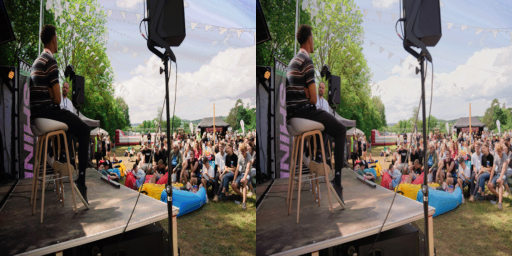

In [123]:
display_images([image30_lut0[0], image30_lut30[0]])

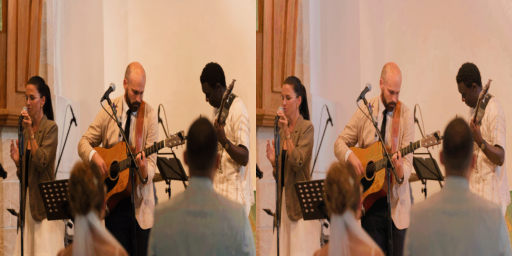

In [124]:
display_images([image0_lut0[0], image0_lut30[0]])

As we can see above the generated LUT is not always the same. It is indeed image-adaptive.

## Performance on Sony images
To evaluate our model, we use 64 unseen images of buildings and cars shot with a Sony camera that are very different from the images in our training data. We will conduct a qualitative assessment of the generated images through visual inspection.

In [125]:
class ValDataset(Dataset):
    def __init__(self, val_images, transform=None):
        self.val_images = val_images
        self.transform = transform

    def __len__(self):
        return len(self.val_images)

    def __getitem__(self, idx):
        val_image = self.val_images[idx]
        if self.transform:
            val_image = self.transform(val_image)
        return val_image

In [126]:
def load_orig_images(directory, num_images):
    images = []
    files = os.listdir(directory)
    
    # Ensure only image files are processed
    image_files = [f for f in files if f.lower().endswith(('.png', '.jpg', '.jpeg'))]

    for i, image_file in enumerate(image_files[:num_images]):
        image_path = os.path.join(directory, image_file)
        img = Image.open(image_path).convert('RGB')
        img = transform(img).unsqueeze(0)
        img = img.to(device)
        images.append(img)

    return images

In [129]:
sony_images = load_orig_images('../../sony_images/Validation', num_images=64)

In [128]:
sony_images_256 = load_images_from_directory('../../sony_images/Validation/256x256', num_images=64)

In [130]:
sony_dataset = ValDataset(sony_images_256.numpy(), transform)
sony_dataloader = DataLoader(sony_dataset, batch_size=batch_size, shuffle=True)

In [131]:
sony_val_images = next(iter(sony_dataloader))
sony_val_images = sony_val_images.to(device)

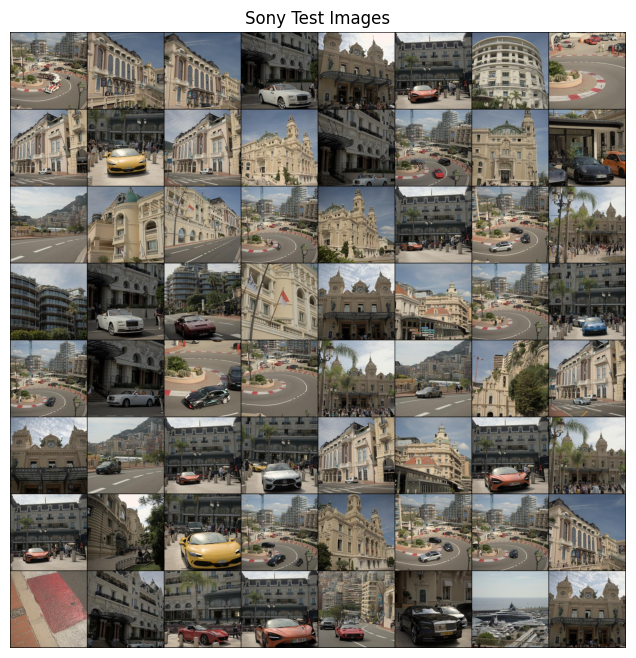

In [132]:
plot_image_grid(sony_val_images, "Sony Test Images")

In [133]:
def save_image(image, output_dir, filename):
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)
    tensor_image = image.detach().cpu()
    # Rearrange to HWC format and scale to [0, 255]
    image_np = np.transpose(tensor_image.numpy(), (1, 2, 0))  # Select the first image in batch and permute to HWC
    image_np = (image_np * 255).clip(0, 255).astype(np.uint8)
            
    img = Image.fromarray(image_np)
    img = img.convert('RGB')
    img.save(os.path.join(output_dir, filename))

In [134]:
for i,sony_img in tqdm(enumerate(sony_images), total=len(sony_images)):
    test = trilinear_interpolation(eval_model(sony_val_images[i].unsqueeze(0))[1], sony_img)
    save_image(test[0], "test_images", f"test_model{i}.jpg")

100%|██████████████████████████████████████████████████████████████████████████████████| 64/64 [02:09<00:00,  2.03s/it]


In [136]:
edited_images_model, luts = eval_model(sony_val_images.to(device))

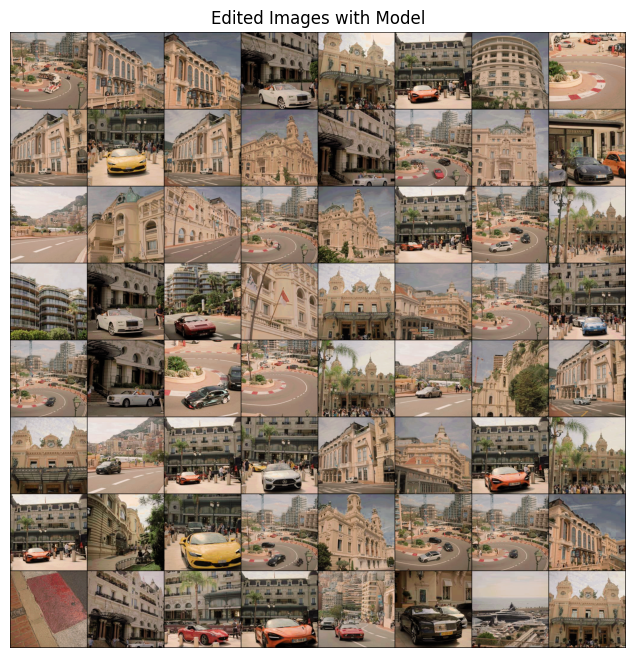

In [137]:
plot_image_grid(edited_images_model, "Edited Images with Model")

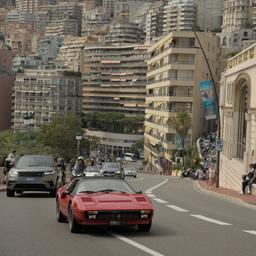

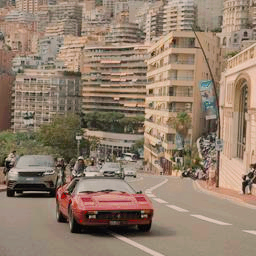

In [146]:
image = 60
display_image(sony_val_images[image])
display_image(edited_images_model[image])

# Conclusion
As you can see above,  our model successfully manages to edit the test images and improve their appearance. \
At the same time, we do not observe obvious artifacts our broken color transitions in the edited images. \
We conclude that our method could be used to automate the editing of images at high resolution at tasks that provide paired image data.   